# SHAP Values

Veremos brevemente un modelo de interpretabilidad para modelos complejos de machine learning como es un LGBM.

El uso de **python** para esta exploración se debe a la madurez encontrada en las librerías en mi búsqueda.

Empezamos con la carga de los módulos necesarios:

In [1]:
import pandas as pd
import numpy as np
import random
import lightgbm as lgb

pd.set_option('display.max_columns', None)

Cargamos con **pandas** lentamente el dataset. Sólo vamos a trabajar con el primer conjunto de datos que es el más pequeño. Con un poco más de paciencia podrá usar los conjuntos más pesados. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Maestría en Explotación de Datos/Especialización/2022 - 2C/Data mining en economía y finanzas/Desafíos/Competencia 2/dataset_7110.csv")

Xtrain = df_train[df_train["foto_mes"].isin([202101, 202102, 202103])]
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (154) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Separamos también todos los casos de **BAJAS+1** y **BAJAS+2**

In [4]:
Xbajas = df_train.query("foto_mes in (202101, 202102, 202103) and clase_ternaria != 'CONTINUA'")

Y nos deshacemos del target y limpiamos un poco la memoria.

In [5]:
Xtrain = Xtrain.drop("clase_ternaria", axis=1)
Xbajas = Xbajas.drop("clase_ternaria", axis=1)

del(df_train)

Hacemos un modelo **LGBM**

In [6]:
random.seed(10)

# create dataset for lightgbm
lgb_train = lgb.Dataset(Xtrain, ytrain)

# specify your configurations as a dict
params = {
    'objective': 'binary',
    'learning_rate': 0.05,
    'verbose': 2,
    'max_bin': 15,
    'min_data_in_leaf': 4000,
    'verbose': 0,
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100)


Y miramos su importancia de variables

In [7]:
lgbm_importancia = pd.DataFrame({'Features': gbm.feature_name(),
                        'Importances': gbm.feature_importance()})
lgbm_importancia.sort_values(by='Importances', inplace=True, ascending=False)
lgbm_importancia


,Features,Importances
8,mrentabilidad_annual,167
33,mprestamos_personales,88
10,mactivos_margen,83
72,mcomisiones_mantenimiento,72
203,total_activos,68
...,...,...
152,Visa_cadelantosefectivo,0
35,mprestamos_prendarios,0
150,Visa_mconsumototal,0
53,mpayroll2,0


Ahora avanzamos aplicando un modelo de interpretabilidad sobre el modelo anterior.

In [8]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.9 MB/s 


In [9]:
import shap

In [10]:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(Xbajas)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Consolidamos los valores de **SHAP** para cada variable y para cada **BAJA+\***

In [11]:
shap_bajas = pd.DataFrame(shap_values[0], columns = Xbajas.columns)
shap_bajas

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,ctrx_quarter_normalizado,mpayroll_sobre_edad,mv_status01,mv_status02,mv_status03,mv_status04,mv_status05,mv_status06,mv_status07,mv_mfinanciacion_limite,mv_Fvencimiento,mv_Finiciomora,mv_msaldototal,mv_msaldopesos,mv_msaldodolares,mv_mconsumospesos,mv_mconsumosdolares,mv_mlimitecompra,mv_madelantopesos,mv_madelantodolares,mv_fultimo_cierre,mv_mpagado,mv_mpagospesos,mv_mpagosdolares,mv_fechaalta,mv_mconsumototal,mv_cconsumos,mv_cadelantosefectivo,mv_mpagominimo,mvr_Master_mlimitecompra,mvr_Visa_mlimitecompra,mvr_msaldototal,mvr_msaldopesos,mvr_msaldopesos2,mvr_msaldodolares,mvr_msaldodolares2,mvr_mconsumospesos,mvr_mconsumosdolares,mvr_madelantopesos,mvr_madelantodolares,mvr_mpagado,mvr_mpagospesos,mvr_mpagosdolares,mvr_mconsumototal,mvr_mpagominimo,vida_banco,mmargen,mmargen_x_producto,total_deuda,total_activos,balance,ratio_deuda,has_cuentacorriente_saldo_pos,has_cajaahorro_saldo_pos,has_saldo_pos,has_internet,has_debito_transacciones,has_visa,has_visa_transacciones,has_master,has_master_transacciones,ctarje

Y consolidamos sus importancias

In [12]:
shap_importancias = shap_bajas.abs().mean().sort_values(ascending=False)
shap_importancias.head(10)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
dtype: float64

La librería nos da útiles herramientas para vizualizar la info anterior

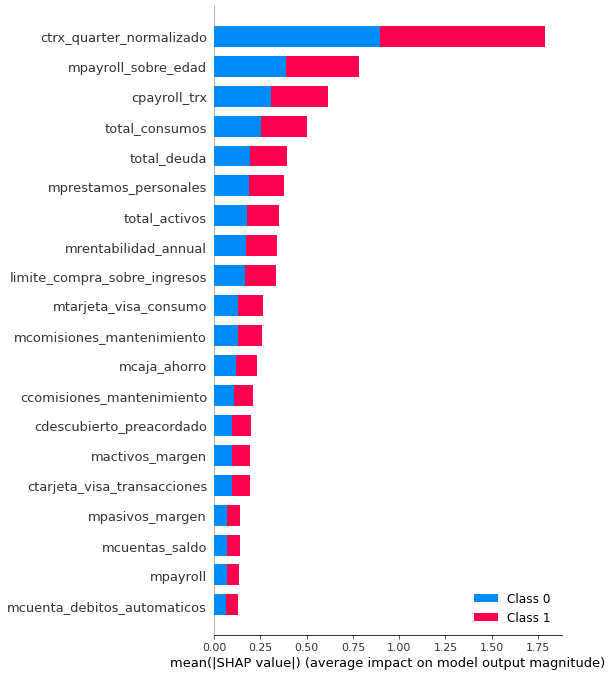

In [13]:
shap.summary_plot(shap_values, Xbajas)

Y ahora debemos empezar a jugar para entender como estan asociadas las variables a los **shap values**

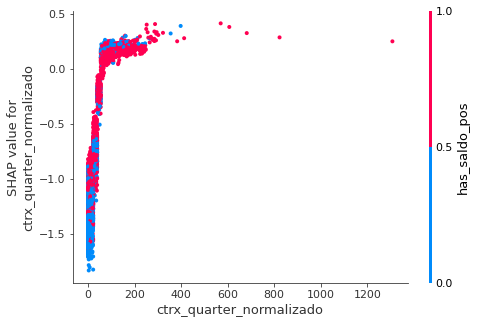

In [14]:
shap.dependence_plot("ctrx_quarter_normalizado", shap_values[0], Xbajas)

¿Se podrá hacer una clusterización sobre los valores de shap? 

Como la cantidad de variables es muy alto, es conveniente hacer un embedding con **UMAP**. Como la estrutura de los **shap values** se pueden hacer sin mucho preprocesamiento.

In [15]:
!pip uninstall umap
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=da134ebe18cbb39e635f1008de798ad09c64101147d771e3c3cfa533539c8c99
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=1b54dcbf4498e6970ace268b8ad9e58a8cbd3cedf7cbdc565759789eafdfd2a4
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [16]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

In [17]:
random.seed(10)

embedding_2d = umap.UMAP(
  n_components=4, n_neighbors=40
).fit_transform(shap_values[0])

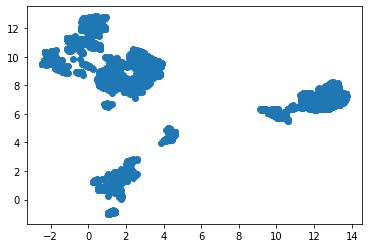

In [18]:
plt.scatter(embedding_2d[:,0], embedding_2d[:,1])

In [19]:
!pip install hdbscan
#!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp37-cp37m-linux_x86_64.whl size=2340679 sha256=3b0b5975af9e782cf52c4228eb0bf15b97a9daa656daaaf119efdb9fc1176eee
  Stored in directory: /root/.cache/pip/wheels/93/78/2e/03ee191669a772e9653260aa3bd53e0b1a768751a9676e8c82
Successfully built hdbscan


In [20]:
import hdbscan

random.seed(10)

from hdbscan.flat import HDBSCAN_flat
clusterer = HDBSCAN_flat(embedding_2d,
                         cluster_selection_method='eom',
                         n_clusters=3, min_cluster_size=20)
labels = clusterer.labels_

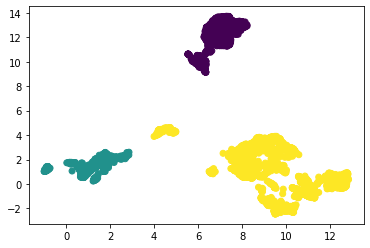

In [21]:
plt.scatter(embedding_2d[:,1], embedding_2d[:,0], c=labels)

Su momento de brillar: Qué se puede hacer desde este punto para tratar de interpretar los distintos segmentos para la presentación de Miranda.

In [22]:
Xbajas['segmento'] = labels

In [23]:
shap_importancias.head(30)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
mcomisiones_mantenimiento       0.128359
mcaja_ahorro                    0.116725
ccomisiones_mantenimiento       0.105325
cdescubierto_preacordado        0.099087
mactivos_margen                 0.098328
ctarjeta_visa_transacciones     0.095909
mpasivos_margen                 0.069542
mcuentas_saldo                  0.069135
mpayroll                        0.067511
mcuenta_debitos_automaticos     0.065213
foto_mes                        0.054909
ccomisiones_otras               0.053448
cproductos                      0.052643
ccaja_seguridad                 0.051662
mv_status01     

In [24]:
import seaborn as sns

Distribución de una variable

In [25]:
def get_variable_distribution(variable):

  print(variable, " (variable importante)" if any(variable in s for s in shap_importancias.head(30).index) else "")

  print("\n")

  display(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))

  print("\n")
  sns.boxplot(x=Xbajas["segmento"], y=Xbajas[variable])
  plt.ylim(np.percentile(Xbajas[variable], 5), np.percentile(Xbajas[variable], 99))
  plt.show()

  #print(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]).to_string())

ctrx_quarter_normalizado  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.737630,69.512239,3.0,9.35,42.0,47.0,54.0,61.0,72.0,85.0,101.5,126.0,166.0,285.0,1308.0
1,718.0,5.323120,8.325746,0.0,0.00,0.0,0.0,0.0,0.0,1.0,3.0,6.0,10.0,17.0,38.0,39.0
2,3111.0,13.541305,11.440893,0.0,0.00,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,51.0


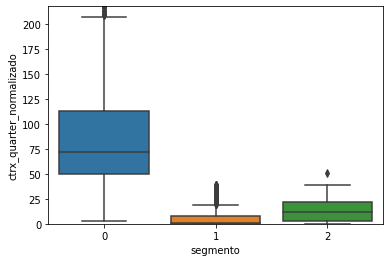

In [26]:
get_variable_distribution("ctrx_quarter_normalizado")

segmentos, principales características

0: cliente más viejos, activos más antiguos, más rentables, ganancia por inversiones/dinero del cliente, con saldo en caja de ahorro (incluso en dolares), usan débito, visa, master, inversiones: usan más plazo fijo, más inversiones, más seguros de vivienda, accidentes personales, perciben salario, débitos automáticos, usan más la app para pagar servicios, más comisiones por otros motivos, reciben más transferencias, envían más transferencias, más extracciones de dinero, usan más la banca telefónica (y el homebanking, y de la app), muchas más transacciones, registran cierta deuda (más x el lado de saldo de las tarjetas), balance bastante positivo. usan más cajeros de otros bancos

1: clientes más nuevos, la mitad sin actividad en el trimestre, algo más jóvenes, mmenos antigüedad, menos rentables, monto cuenta corriente bastante negativo, sin descubierto preacordado, saldo muy negativo, no usan tarjeta débito, no tienen visa, no tienen master, más créditos personales (y hipotecarios), no perciben salario, tarjeta en estado cerrado (más morosidad), límites más chicos, registran cierta deuda (más x el lado de saldos negativos y créditos), balance muy negativo. la mayoría no tiene tarjeta (y el uso es todavía menor). comisiones/producto y comisiones/trx muy alto

2: cuenta corriente en negativo (no tanto como 1), la mayoría tiene descubierto preacordado, saldo negativo la mayoría, pero menos q 1. no usan tarjeta débito, un poquito más de uso de tarjeta que 1, no perciben salario, mayores montos de comisiones de mantenimiento, tarjeta en estado cerrado (más morosidad), límites más chicos, practicamente no endeudados, balance algo positivo. la mayoría tiene tarjetas, pero el uso es considerablemente menor a 0. comisiones/producto y comisiones/trx muy alto

ofrecer maás descuentos, se usan poco.

In [27]:
bbomitir_cols = ['cliente_vip', 'tcuentas', 'foto_mes', 'ccaja_ahorro', 'mcaja_ahorro_adicional', 'cforex', 'cforex_buy', 'mforex_buy', 'cforex_sell', 'mforex_sell', 'ccheques_depositados', 'mcheques_depositados', 'ccheques_emitidos', 'mcheques_emitidos' \
               'ccheques_depositados_rechazados', 'mcheques_depositados_rechazados', 'ccheques_emitidos_rechazados', 'mcheques_emitidos_rechazados']

for variable in Xbajas.columns[~Xbajas.columns.isin(omitir_cols)]:
  print(variable, " (variable importante)" if any(variable in s for s in shap_importancias.head(30).index) else "")

  print("\n")

  display(Xbajas.groupby('segmento')[variable].describe(percentiles = [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]))

  print("\n")

numero_de_cliente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9.963355e+07,4.156962e+07,31127916.0,32756243.0,40861092.5,63306576.0,75469348.0,83332219.0,95505137.5,110834167.0,122413453.5,137820004.0,154976174.0,1.960704e+08,210415097.0
1,718.0,1.173769e+08,4.303593e+07,31282207.0,34650605.0,58429807.8,75909229.2,87604791.0,107692593.0,120027239.5,134736028.8,148055738.1,157333918.6,173558042.0,1.951680e+08,203919930.0
2,3111.0,1.113542e+08,4.617751e+07,31229316.0,32646021.7,44038414.0,67670816.0,81100031.0,93086152.0,108223657.0,124022455.0,139397018.0,155381898.0,176712856.0,2.050894e+08,212170051.0




active_quarter 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.490251,0.500253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,0.777242,0.416164,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




internet 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.063151,0.289754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,718.0,0.236769,0.453945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
2,3111.0,0.130826,0.390298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0




cliente_edad 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,48.500651,13.731060,20.0,25.0,31.0,35.0,39.0,43.0,47.0,52.0,56.0,62.0,67.0,79.65,88.0
1,718.0,46.307799,13.703931,19.0,23.0,30.0,34.0,38.0,40.0,44.0,48.0,53.0,59.0,66.0,80.00,88.0
2,3111.0,49.141112,14.171833,21.0,24.0,31.0,36.0,40.0,43.0,48.0,52.0,57.0,63.0,69.0,81.00,93.0




cliente_antiguedad 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,127.460286,81.363917,1.0,8.0,34.0,55.0,70.0,90.0,115.5,140.0,165.0,193.0,236.0,322.0,375.0
1,718.0,100.839833,74.048860,7.0,14.0,33.0,42.0,50.0,59.0,70.0,94.2,128.0,162.0,204.0,321.0,374.0
2,3111.0,103.562199,82.766952,1.0,6.0,17.0,34.0,44.0,58.0,75.0,108.0,135.0,173.0,226.0,322.0,375.0




mrentabilidad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1890.886719,5198.878239,-25374.53,-5930.6800,-1133.945,-52.50,231.345,607.830,1190.17,1649.100,2070.815,2749.610,4624.960,23382.4380,70015.54
1,718.0,922.825877,4973.887573,-26669.56,-15482.0154,-783.790,-60.90,3.061,113.426,661.99,1328.238,1683.988,2152.058,3101.618,14914.6903,85517.62
2,3111.0,1744.271501,5738.525409,-34343.51,-4286.8130,0.000,142.16,573.570,1271.860,1504.85,1729.470,1978.140,2377.740,3126.650,11534.6770,160117.54




mrentabilidad_annual  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16059.062988,45651.551912,-96147.95,-41220.9000,-7615.485,-184.240,2865.345,5441.330,8037.905,11214.070,16235.345,24884.530,43143.345,153341.3205,772601.07
1,718.0,11089.168872,31281.403834,-103230.51,-47579.8966,-7360.602,49.862,1742.067,4093.312,7166.400,9989.148,14119.754,18568.524,28124.565,123034.1954,482765.63
2,3111.0,12950.881925,31459.931495,-192280.71,-23186.2990,0.000,1847.720,3804.440,5729.160,7868.610,10929.230,15630.270,20483.400,27848.590,83167.8380,816480.24




mcomisiones  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1478.550345,2570.919477,-13432.52,-570.8085,39.545,159.57,323.28,637.40,1224.295,1592.20,1844.335,2249.08,2871.00,10364.3180,49309.58
1,718.0,666.140125,1515.944335,-15682.01,-1730.5300,0.000,0.00,0.00,0.00,23.600,737.18,1225.040,1592.20,1730.53,3133.1468,19145.58
2,3111.0,1181.097850,1274.270633,-12175.36,-1034.7870,0.000,49.58,273.70,1225.04,1266.480,1592.20,1676.170,1811.47,2257.35,3407.6330,30177.57




mactivos_margen  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-448.565098,3001.247517,-22551.41,-8258.8880,-2662.715,-1403.650,-728.53,-334.55,-138.580,-22.350,0.275,79.230,685.120,9441.4475,43736.84
1,718.0,61.552479,2944.725161,-25347.85,-13407.6213,-599.858,-129.856,0.00,0.00,8.635,58.456,217.381,449.966,1615.593,8588.8794,19880.00
2,3111.0,341.338335,4657.126356,-39907.34,-4097.9790,-350.080,-74.330,-1.60,2.90,26.160,84.470,170.960,355.230,863.660,6664.1280,134010.69




mpasivos_margen  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,800.086699,2651.974671,-3655.73,-555.3935,13.995,57.95,113.535,192.390,279.815,394.050,592.610,865.160,1501.935,8740.7900,56835.10
1,718.0,157.275905,2725.238751,-374.84,0.0000,0.000,0.00,0.010,0.438,1.720,5.454,17.525,43.556,118.527,1076.7079,72856.90
2,3111.0,138.775047,963.791691,-6742.26,-369.1720,0.000,0.00,0.390,4.210,12.870,31.270,63.010,127.160,293.150,2155.5990,37439.34




cproductos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6.850260,1.341291,3.0,4.00,5.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,8.0,10.0,14.0
1,718.0,4.995822,1.085589,3.0,3.17,4.0,4.0,4.0,4.0,5.0,5.0,5.0,6.0,6.0,8.0,10.0
2,3111.0,6.312440,1.209596,4.0,4.00,5.0,5.0,6.0,6.0,6.0,7.0,7.0,7.0,8.0,9.0,11.0




ccuenta_corriente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,1.000643,0.025351,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0




mcuenta_corriente_adicional 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,718.0,-52.959485,1419.077038,-38024.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3111.0,4.236307,236.285676,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13179.15




mcuenta_corriente 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-13.849499,37254.317515,-969864.61,-28490.8895,-4536.335,-1493.61,-480.2,-175.680,-25.340,0.00,0.000,0.0,0.0,42107.7020,663743.51
1,718.0,-27641.231170,115412.387592,-1168765.97,-691101.7700,-33329.197,-17078.13,-10638.3,-5598.544,-1480.495,-333.80,-48.757,0.0,0.0,490.8495,1677.14
2,3111.0,-7905.632253,43429.588004,-1372480.76,-71074.2600,-19286.460,-8409.22,-4368.7,-2142.300,-754.230,-244.76,-51.240,0.0,0.0,1221.6890,115097.50




mcaja_ahorro  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,35540.654967,159780.831539,0.0,0.0,0.0,268.99,1515.035,3437.95,6310.635,10568.82,17601.195,32488.67,64853.325,420823.2430,3989708.85
1,718.0,2668.710989,37291.820262,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.02,16.479,159.75,1315.333,27828.0798,965984.26
2,3111.0,6279.331025,65516.587109,0.0,0.0,0.0,0.00,0.000,0.00,3.070,131.90,763.160,2422.91,9228.560,70522.1360,2752487.19




mcaja_ahorro_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,28193.867233,258104.697189,-1130.77,0.0,0.0,0.0,0.0,0.0,0.0,9.71,102.5,3758.36,29215.75,499637.0075,7984516.08
1,718.0,7044.764290,176738.944322,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,48.54,4701.6529,4734429.08
2,3111.0,18145.827306,302648.648053,-8.63,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,11.58,468.87,236845.7590,14306348.63




cdescubierto_preacordado  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.901042,0.298703,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.975571,0.154403,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




mcuentas_saldo  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,59485.221914,351284.149429,-907864.11,-33490.7735,-4617.680,-1756.690,0.00,475.46,3213.995,10464.460,25602.815,52302.08,115747.310,760195.9600,9773714.32
1,718.0,-21789.262006,189505.567620,-1168266.01,-691072.0410,-33858.665,-17735.834,-11541.36,-5555.19,-2355.370,-1554.042,0.010,61.65,716.608,26308.0912,3808293.81
2,3111.0,14892.691254,317223.329490,-1347146.44,-86029.9030,-19849.070,-9680.440,-5195.86,-2974.10,-1730.550,-164.020,65.640,1663.31,13269.170,346129.4290,14392871.70




ctarjeta_debito 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.475260,0.790440,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,7.0
1,718.0,1.298050,0.564176,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,3.0
2,3111.0,1.465124,0.727053,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,7.0




ctarjeta_debito_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4.527344,7.818330,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,8.0,14.0,35.00,77.0
1,718.0,0.091922,0.724095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.83,9.0
2,3111.0,0.194793,0.913978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00,21.0




mautoservicio  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9252.438288,18681.127960,0.0,0.0,0.0,0.0,0.0,0.0,1153.095,3418.21,7571.565,13794.06,26923.795,90651.5060,215080.02
1,718.0,303.163955,2856.244899,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.000,9575.6495,42924.76
2,3111.0,444.717441,3379.339422,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.000,0.00,0.000,10282.8880,113176.84




ctarjeta_visa  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.858724,0.352139,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
1,718.0,0.227019,0.422511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
2,3111.0,0.776921,0.423271,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0




ctarjeta_visa_transacciones  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9.325521,12.763936,0.0,0.0,0.0,0.0,1.0,3.0,5.0,8.0,11.0,16.0,25.0,55.65,153.0
1,718.0,0.373259,1.789465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.66,20.0
2,3111.0,1.477981,3.476621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,16.00,63.0




mtarjeta_visa_consumo  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,19911.689980,34726.481485,0.0,0.0,0.0,0.0,704.85,3872.17,8630.845,13838.23,19875.225,30435.32,54516.315,157713.7090,455312.33
1,718.0,771.794206,5575.914488,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.00,0.000,16864.0358,124786.81
2,3111.0,3123.773455,9629.799460,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,694.410,2975.50,9291.220,42957.9180,152492.14




ctarjeta_master 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.785156,0.410848,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.229805,0.424301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
2,3111.0,0.680489,0.466362,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




ctarjeta_master_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.610677,5.302030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,25.65,81.0
1,718.0,0.104457,1.230236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,31.0
2,3111.0,0.134362,1.012437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,32.0




mtarjeta_master_consumo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4069.546217,15569.065451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,967.0,9592.115,70615.634,355325.45
1,718.0,222.066727,2025.366020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5863.820,36934.16
2,3111.0,352.168312,3017.649278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,9192.086,108718.14




cprestamos_personales 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.438151,5.293111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,147.0
1,718.0,0.190808,1.225519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,19.0
2,3111.0,0.316297,2.304809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,57.0




mprestamos_personales  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9191.671504,64619.898117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229258.0085,1372139.34
1,718.0,791.552075,3406.504288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18755.5374,24610.05
2,3111.0,6965.744057,48268.795550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231547.1740,912170.08




cprestamos_prendarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000651,0.025516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.021858,0.284946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0




mprestamos_prendarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,92.888704,3640.478859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142677.05
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3111.0,2117.603607,36033.530120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1193353.13




cprestamos_hipotecarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.008464,0.141858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,718.0,0.055710,0.746700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
2,3111.0,0.003536,0.073849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0




mprestamos_hipotecarios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,10888.573867,209872.103823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4921362.77
1,718.0,10387.302423,192157.618898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3702154.83
2,3111.0,166.470501,4617.453491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164626.67




cplazo_fijo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.145182,1.384094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,44.0
1,718.0,0.005571,0.074483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.015108,0.124609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




mplazo_fijo_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,37197.037227,266385.703478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1152472.5,5494332.00
1,718.0,13585.642618,350454.044647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9384000.00
2,3111.0,4464.459724,61093.729333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111904.2,2271369.04




mplazo_fijo_pesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,9334.794421,316158.970552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12308825.61
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3111.0,174.413986,9728.173614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,542601.91




cinversion1 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.020182,0.170025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1,718.0,0.004178,0.064549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.007072,0.097961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0




minversion1_pesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2241.495026,56791.308844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16884.11,2193329.94
1,718.0,4.145348,78.495276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1507.93
2,3111.0,516.978364,12820.149901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,471242.21




minversion1_dolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,718.0,144.419499,3869.795854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,103693.2
2,3111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




cinversion2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.082031,1.414597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,38.0
1,718.0,0.002786,0.052741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.016393,0.177663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0




minversion2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1714.037643,32598.764165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1398.5855,1005463.37
1,718.0,499.320850,9454.848872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,181385.84
2,3111.0,238.428856,7909.578787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.4590,313942.18




cseguro_vida 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050130,0.218285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,718.0,0.026462,0.160618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.041466,0.201003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




cseguro_auto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.016927,0.179685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1,718.0,0.001393,0.037320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.014143,0.138176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0




cseguro_vivienda 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.114583,0.324698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,718.0,0.025070,0.156446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.057216,0.241788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




cseguro_accidentes_personales 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.126953,0.334979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
1,718.0,0.034819,0.183449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.086146,0.280625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ccaja_seguridad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.022135,0.151534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,718.0,0.004178,0.064549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.013500,0.115423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




cpayroll_trx  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.309245,0.884948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,18.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mpayroll  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,22550.933047,134560.516188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54657.725,323300.019,3523523.08
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.00
2,3111.0,2.601639,125.842448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,6920.70




mpayroll2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,60.1125,1592.704063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52949.33
1,718.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3111.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00




cpayroll2_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001953,0.044165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




ccuenta_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.696615,1.653468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,5.0,35.0
1,718.0,0.041783,0.220139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,3111.0,0.122147,0.410311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0




mcuenta_debitos_automaticos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2089.652292,11623.988169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.49,1439.02,5290.36,27678.278,290826.17
1,718.0,19.725613,230.180055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,162.412,3647.90
2,3111.0,140.632932,1314.118791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3546.758,39658.66




ctarjeta_visa_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.923828,2.797869,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0,5.0,13.00,20.0
1,718.0,0.097493,0.540127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.83,6.0
2,3111.0,0.453230,1.052778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.00,8.0




mttarjeta_visa_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4315.505137,9164.187725,0.0,0.0,0.0,0.0,0.0,0.0,532.77,1852.17,4211.645,6439.77,12237.26,38249.0405,140694.65
1,718.0,194.246462,1610.454925,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.00,7007.4297,31048.66
2,3111.0,803.959090,2914.375863,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.000,445.91,2029.09,13216.9380,53377.57




ctarjeta_master_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.291016,1.197423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.00,13.0
1,718.0,0.020891,0.238213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.83,4.0
2,3111.0,0.042430,0.339472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,9.0




mttarjeta_master_debitos_automaticos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,650.213333,3321.655318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,196.71,16524.2440,62418.08
1,718.0,48.561978,682.649591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,433.2434,15348.00
2,3111.0,74.563848,942.502279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1544.8410,30820.65




cpagodeservicios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.023438,0.475563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.000643,0.025351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mpagodeservicios 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,96.498171,1809.326654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47360.74
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3111.0,7.419495,300.485317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14241.68




cpagomiscuentas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.607422,3.279020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,16.0,39.0
1,718.0,0.032033,0.358719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
2,3111.0,0.072645,0.457022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0




mpagomiscuentas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,8900.300078,45837.015873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2082.1,7821.63,20445.415,117076.6655,1074363.35
1,718.0,75.992786,918.912276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,1362.8698,20907.68
2,3111.0,199.125641,2206.545251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,4689.5050,87997.94




ccajeros_propios_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045573,0.289681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,718.0,0.001393,0.037320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.000321,0.017929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mcajeros_propios_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,10.099388,159.892468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.9665,5622.48
1,718.0,0.163370,4.377597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,117.30
2,3111.0,0.378782,21.127059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1178.39




ctarjeta_visa_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050130,0.303229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
1,718.0,0.001393,0.037320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.008036,0.114537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0




mtarjeta_visa_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1519.0,21.706228,240.075978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,375.1846,5213.16
1,718.0,0.293900,7.875196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,211.02
2,3104.0,4.623640,123.039455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,5027.94




ctarjeta_master_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.027344,0.271144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,718.0,0.001393,0.037320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.001607,0.040064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




mtarjeta_master_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1521.0,1.188409,21.160347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,588.17
1,717.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,3107.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00




ccomisiones_mantenimiento  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.582682,0.624943,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0
1,718.0,0.538997,0.672646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,4.0
2,3111.0,0.732562,0.580911,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.9,7.0




mcomisiones_mantenimiento  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,932.539668,1110.936123,-7878.47,0.00,0.0,0.0,0.0,0.00,0.00,1364.94,1774.04,1774.04,2505.95,3413.33,4469.03
1,718.0,675.355446,994.088097,-4094.84,-1928.17,0.0,0.0,0.0,0.00,0.00,1364.94,1364.94,1622.81,1774.04,2626.15,3413.33
2,3111.0,1141.619650,1039.908487,-6824.74,-1364.94,0.0,0.0,0.0,1364.94,1364.94,1622.81,1774.04,1928.17,2505.95,3413.33,4229.34




ccomisiones_otras  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7.398438,4.181248,0.0,0.0,2.0,4.0,4.0,6.0,6.0,8.0,8.0,10.0,12.0,21.00,52.0
1,718.0,1.821727,2.176065,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,4.0,4.0,8.83,13.0
2,3111.0,3.463838,2.693907,0.0,0.0,0.0,2.0,2.0,2.0,2.0,4.0,4.0,6.0,6.0,12.00,27.0




mcomisiones_otras 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1479.109915,2571.008034,-13432.52,-570.8085,39.545,161.21,323.28,637.40,1224.295,1592.20,1844.335,2249.08,2871.00,10364.3180,49309.58
1,718.0,666.131741,1515.948752,-15682.01,-1730.5300,0.000,0.00,0.00,0.00,23.600,737.18,1225.040,1592.20,1730.53,3133.1468,19145.58
2,3111.0,1181.268833,1274.416421,-12175.36,-1034.7870,0.000,49.58,273.70,1225.04,1264.820,1592.20,1676.170,1813.76,2264.47,3407.6330,30177.57




ctransferencias_recibidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.707031,9.402618,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,4.0,6.0,13.0,260.0
1,718.0,0.239554,1.056821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,15.0
2,3111.0,0.459016,1.115302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,20.0




mtransferencias_recibidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,63933.617904,265586.852738,0.0,0.0,0.0,0.0,791.775,7272.6,17008.5,29442.3,47109.435,74602.8,124357.955,596653.9425,6038470.92
1,718.0,1979.421741,12693.346835,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,1613.213,43657.7171,187918.72
2,3111.0,8503.858888,74268.806122,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,3519.0,11730.000,114742.4810,1963277.91




ctransferencias_emitidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.006510,3.846733,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,6.0,15.0,67.0
1,718.0,0.065460,0.428945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0
2,3111.0,0.139184,0.574578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0




mtransferencias_emitidas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,46355.263757,230022.582172,0.0,0.0,0.0,0.0,0.0,0.0,381.5,4966.99,14076.0,32515.56,78542.47,812576.1595,4420853.06
1,718.0,2677.995223,55622.337602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,20344.2364,1480795.20
2,3111.0,3111.532073,52994.385490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,44914.6240,2521954.44




cextraccion_autoservicio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.585938,3.327377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,5.0,15.65,30.0
1,718.0,0.071031,0.652618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,13.0
2,3111.0,0.103825,0.618957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,11.0




mextraccion_autoservicio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,13950.241400,35070.710038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5865.0,17595.0,43225.05,177064.350,414069.0
1,718.0,434.728830,3650.184609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,16941.639,54309.9
2,3111.0,891.894809,6764.292581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,26861.700,199761.9




mcheques_emitidos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2599.135905,44140.148578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19310.5125,1467657.60
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00
2,3111.0,69.106342,2705.750402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,141372.35




ccheques_depositados_rechazados 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001302,0.036073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




tcallcenter  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.160156,0.366870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,718.0,0.071031,0.257055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.100289,0.300434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0




ccallcenter_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.960938,4.119680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.00,86.0
1,718.0,0.295265,1.495416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.83,18.0
2,3111.0,0.426872,1.766890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.00,28.0




thomebanking  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.769531,0.421270,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.243733,0.429633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,3111.0,0.462552,0.498676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0




chomebanking_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,45.500651,67.349765,0.0,0.0,0.0,2.0,6.0,12.0,21.0,35.0,53.0,75.0,116.0,320.85,800.0
1,718.0,4.632312,15.437864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,84.83,150.0
2,3111.0,10.366442,21.084017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,17.0,35.0,99.80,228.0




ccajas_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.115885,0.320192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,718.0,0.192201,0.394305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,3111.0,0.057859,0.233515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ccajas_consultas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.166667,0.849347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,16.0
1,718.0,0.590529,1.964687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.83,18.0
2,3111.0,0.121826,0.767681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,18.0




ccajas_depositos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.052083,0.324698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1,718.0,0.029248,0.191834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,3111.0,0.013822,0.127309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0




ccajas_extracciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.057943,0.303983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
1,718.0,0.006964,0.083216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.015429,0.153480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0




ccajas_otras 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.057292,0.348994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0
1,718.0,0.267409,0.896808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,8.0
2,3111.0,0.030537,0.386300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,18.0




catm_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.097656,2.784245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,12.65,30.0
1,718.0,0.041783,0.499297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,11.0
2,3111.0,0.078110,0.543308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,11.0




matm 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,11231.784473,32807.257192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11143.5,35190.0,163809.45,402339.0
1,718.0,302.888858,2976.768179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12680.13,47271.9
2,3111.0,762.906284,6590.461699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24515.70,199761.9




catm_trx_other 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.488281,1.606134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,28.0
1,718.0,0.029248,0.313316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
2,3111.0,0.025715,0.289107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0




matm_other 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2718.456927,11027.689299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8211.0,42228.000,228735.0
1,718.0,131.839972,1507.095780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1033.413,30498.0
2,3111.0,128.988525,1486.762794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2873.850,35190.0




ctrx_quarter  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.600911,69.579914,3.0,8.0,41.5,47.0,53.0,61.0,72.0,85.0,101.5,126.0,165.5,285.0,1308.0
1,718.0,5.323120,8.325746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,10.0,17.0,38.0,39.0
2,3111.0,13.531019,11.439211,0.0,0.0,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,51.0




tmobile_app 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050781,0.219622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,718.0,0.002786,0.052741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.015751,0.124529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




cmobile_app_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.688802,0.463134,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.169916,0.375821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,3111.0,0.331405,0.470794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




Master_delinquency 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.007981,0.089014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,205.0,0.048780,0.215936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2237.0,0.014305,0.118771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




Master_status 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.334397,1.696380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,205.0,1.741463,3.505806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.4,9.0,9.0,9.0
2,2237.0,0.465802,1.964196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




Master_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,298132.456640,402782.318948,0.0,25336.8,63342.00,76010.4,88678.8,126684.00,177357.6,202694.4,253368.00,493630.3,709430.40,1.399943e+06,4323273.29
1,205.0,178934.609707,207372.818090,0.0,0.0,46873.08,63342.0,63342.0,83611.44,88678.8,101347.2,177357.60,253368.0,438064.26,8.529551e+05,1335242.75
2,2237.0,244761.909423,346976.931248,0.0,25336.8,50673.60,63342.0,88678.8,101347.20,126684.0,177357.6,212829.12,304041.6,520717.70,1.399943e+06,3705662.82




Master_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,-988.499601,541.123412,-2221.0,-2190.00,-1643.0,-1507.8,-1340.0,-1184.0,-882.0,-670.0,-578.0,-486.0,-364.0,-105.56,-60.0
1,205.0,-1054.414634,585.381783,-2221.0,-2216.88,-2027.0,-1497.0,-1401.0,-1248.0,-1094.0,-837.8,-667.6,-486.0,-255.2,-58.08,122.0
2,2237.0,-1067.160930,587.330027,-2221.0,-2190.00,-1836.2,-1580.0,-1460.0,-1308.2,-1125.0,-760.0,-637.0,-517.0,-333.0,-88.00,3989.0




Master_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,10.0,43.2000,44.802778,13.0,13.27,15.7,16.0,18.8,20.0,21.5,23.0,31.4,63.2,114.6,135.66,138.0
1,10.0,77.5000,45.901465,16.0,16.36,19.6,44.8,52.4,68.6,80.0,83.0,93.2,110.0,115.9,163.69,169.0
2,32.0,52.1875,48.693536,6.0,6.93,16.0,20.0,20.0,27.0,35.5,48.0,51.0,54.2,135.4,169.00,169.0




Master_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,7896.417965,35279.817828,-12982.84,-356.6500,0.0,0.0,0.0,0.0,0.0,0.0,296.444,4038.456,21766.794,106251.7176,766890.02
1,205.0,8657.585854,52586.215354,-848.51,-84.6508,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,8665.320,182394.6708,613615.67
2,2237.0,1623.023076,18159.072271,-77415.30,-305.8132,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,163.654,31904.6396,603541.48




Master_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,7864.650128,35176.328061,-12982.84,-323.1932,0.0,0.0,0.0,0.0,0.0,0.0,321.296,4013.486,21798.064,105866.5336,766890.02
1,205.0,8657.585854,52586.215354,-848.51,-84.6508,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,8665.320,182394.6708,613615.67
2,2237.0,1641.512204,18053.396923,-15263.63,-270.8500,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,178.520,31611.2424,603541.48




Master_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,31.767741,778.158168,-18255.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1237.23,11179.05
1,205.0,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
2,2237.0,-18.489146,1952.365567,-84684.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,31066.41




Master_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,9563.154876,22787.104061,-880.98,0.0,0.0,0.0,0.0,727.448,1990.72,3992.46,7755.108,13093.942,29601.574,85131.8976,355207.21
1,46.0,1687.886087,5372.448748,0.00,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.000,998.050,3854.245,24527.2525,32037.55
2,292.0,2143.603596,6484.605241,-765.73,0.0,0.0,0.0,0.0,0.000,0.00,0.00,520.630,1388.830,5376.424,31415.9518,55059.07




Master_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,1.720989,10.712272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.9340,120.37
1,46.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00
2,292.0,3.291575,35.142199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.5066,483.13




Master_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,332007.486209,447682.970476,12316.50,28152.00,70380.0,84456.0,98532.0,140760.0,197064.0,225216.0,281520.0,548557.67,788256.000,1.555492e+06,4803636.99
1,205.0,201083.942927,229115.013517,5700.78,8867.88,56304.0,70380.0,70380.0,98532.0,112608.0,123868.8,197064.0,281520.00,486785.802,9.477279e+05,1483603.06
2,2237.0,272072.427009,385349.930455,5700.78,28152.00,56304.0,70380.0,98532.0,112608.0,140760.0,197064.0,236476.8,337824.00,578659.140,1.555492e+06,4117403.13




Master_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,34.267416,433.426338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7038.0
1,46.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,292.0,42.179795,523.103207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7624.5




Master_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,292.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




Master_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,2.728651,6.088127,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,25.0
1,205.0,2.663415,5.966317,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,25.0
2,2237.0,2.435852,5.412007,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,7.0,21.0,25.0




Master_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,1429.471804,11942.015419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40581.3304,293250.00
1,205.0,56.539610,409.939497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2413.0784,3519.00
2,2237.0,401.526008,12900.438355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1480.0628,603541.48




Master_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,-13688.121775,21543.998608,-163665.94,-107488.9912,-34470.816,-21764.030,-13320.484,-8835.576,-5675.030,-3205.008,-1601.278,-619.91,-33.344,0.000,199.43
1,46.0,-5840.422391,12399.236283,-75860.18,-55024.9190,-12965.490,-9309.560,-6392.850,-2765.450,-1084.810,-36.140,0.000,0.00,0.000,505.376,848.51
2,292.0,-5091.927260,12227.277413,-132208.43,-50574.7387,-11730.000,-7373.364,-3789.927,-2096.616,-957.335,-528.240,-182.609,0.00,0.000,0.000,1042.69




Master_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,4.301618,56.893767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.2864,1171.17
1,46.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.00
2,292.0,1.054384,16.521760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0005,281.74




Master_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,2367.504389,1819.267401,6.0,56.12,368.2,544.0,1051.0,1590.8,2006.0,2489.4,3173.0,3904.0,4981.2,7543.00,7587.0
1,205.0,1906.512195,1626.750278,103.0,189.00,427.6,582.6,811.6,1078.0,1334.0,1725.8,2063.0,3165.2,4816.8,6450.76,7215.0
2,2237.0,1910.057219,1690.365482,2.0,72.36,273.0,420.0,606.8,982.4,1405.0,1842.8,2517.6,3354.2,4507.4,7520.40,7602.0




Master_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,9563.154876,22787.104061,-880.98,0.0,0.0,0.0,0.0,727.448,1990.72,3992.46,7755.108,13093.942,29601.574,85131.8976,355207.21
1,46.0,1687.886087,5372.448748,0.00,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.000,998.050,3854.245,24527.2525,32037.55
2,292.0,2143.603596,6484.605241,-765.73,0.0,0.0,0.0,0.0,0.000,0.00,0.00,520.630,1388.830,5376.424,31415.9518,55059.07




Master_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,3.568539,5.703476,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,3.8,6.0,10.0,23.56,60.0
1,46.0,0.434783,0.934575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.00,4.0
2,292.0,0.962329,3.126533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,7.72,35.0




Master_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,445.0,0.015730,0.195039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,46.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,292.0,0.023973,0.314769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0




Master_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,1922.961716,22747.704962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,340.17,2263.890,22441.3668,766883.94
1,205.0,4292.665024,25930.023228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1637.508,139794.8556,231045.81
2,2237.0,804.273192,11183.153493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,10132.8432,414714.15




Visa_delinquency 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.021199,0.144099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,205.0,0.107317,0.310274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2541.0,0.026368,0.160257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




Visa_status 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.332602,1.692461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,205.0,1.795122,3.477797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,9.0,9.0,9.0
2,2541.0,0.454545,1.941669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




Visa_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,298837.602939,363960.518382,505.56,25336.8,63342.0,88678.8,101347.2,126684.0,177357.6,202694.4,253368.0,481176.33,703564.995,1399942.650,3481876.80
1,205.0,173645.641073,187535.253869,0.00,0.0,38005.2,63342.0,63342.0,88678.8,101347.2,177357.6,202694.4,253368.00,354715.200,989055.296,1335242.75
2,2541.0,237107.125946,287179.457614,0.00,25336.8,63342.0,76010.4,101347.2,126684.0,177357.6,177357.6,253368.0,253368.00,506736.000,1399942.650,3512896.64




Visa_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,-5529.474415,111338.289355,-2914178.0,-2190.00,-1916.0,-1766.0,-1643.0,-1521.0,-1309.0,-1156.0,-943.0,-788.0,-548.0,-110.77,366.0
1,205.0,-1333.800000,626.184551,-2220.0,-2216.88,-2037.0,-1855.0,-1735.0,-1613.0,-1521.0,-1388.6,-1125.0,-790.0,-272.8,25.52,1005.0
2,2541.0,-7063.635577,129111.848754,-2914237.0,-2218.00,-2008.0,-1884.0,-1763.0,-1641.0,-1488.0,-1245.0,-1004.0,-759.0,-456.0,-60.00,2617.0




Visa_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,29.0,16.137931,22.384185,0.0,0.0,0.0,0.0,0.0,2.8,17.0,17.0,20.2,24.0,28.0,94.52,113.0
1,22.0,48.181818,40.950186,0.0,0.0,1.4,21.0,21.0,28.0,49.0,50.8,56.9,77.4,86.8,158.03,170.0
2,67.0,32.582090,37.705457,0.0,0.0,0.0,1.4,17.0,21.0,21.0,21.0,30.0,51.4,74.0,170.00,170.0




Visa_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,24292.806857,39760.641751,-63993.57,-296.0438,0.0,843.688,3451.721,7320.934,11744.945,16344.902,23591.781,35966.302,60595.615,205027.0856,400980.16
1,205.0,12583.005122,52912.960244,-46587.27,-2648.3324,0.0,0.000,0.000,0.000,0.000,96.864,2634.212,7549.738,26313.214,302533.2972,495899.95
2,2541.0,5703.883778,33005.187700,-119926.06,-3670.7980,0.0,0.000,0.000,0.000,0.000,606.570,2116.100,5391.060,12718.350,79137.2640,1157351.65




Visa_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,28153.756469,46224.121897,-84667.10,-344.1116,0.0,989.64,4128.15,8466.544,13787.76,19057.558,27552.427,41791.508,70342.256,230342.4827,470349.72
1,205.0,15013.559659,61880.032643,-8063.06,-771.5592,0.0,0.00,0.00,0.000,0.00,128.336,2843.790,8855.838,30865.398,354871.5520,581690.64
2,2541.0,6761.372731,38623.938435,-140673.26,-3188.4540,0.0,0.00,0.00,0.000,0.00,708.860,2573.240,6327.190,15051.040,93781.1820,1357573.48




Visa_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,342.654978,3223.442516,-15104.69,-1277.9908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9212.0040,67547.62
1,205.0,-253.696195,3962.969515,-56570.35,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.4272,4084.70
2,2541.0,-70.719339,2423.463151,-77159.22,-40.9160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.5700,35844.02




Visa_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,17124.35754,31208.741615,-7082.48,-3.1200,0.0,902.628,2479.406,4915.658,7313.10,10944.700,16901.850,25025.872,44845.640,125374.1138,450300.75
1,100.0,2965.95250,11516.428772,-1255.69,-119.3779,0.0,0.000,0.000,0.000,0.00,81.854,694.403,2153.964,7002.308,33313.1435,107402.12
2,1326.0,4213.78037,10510.796415,-4451.33,-6.5075,0.0,0.000,0.000,462.150,803.84,1498.550,3071.035,5727.250,11042.395,40984.0875,128039.98




Visa_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,7.703188,58.052930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.81,6.174,169.6864,1113.39
1,100.0,1.043000,5.806880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,32.7103,45.61
2,1326.0,0.778333,11.038981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,13.4875,385.95




Visa_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,332084.717632,404422.684589,1011.71,28152.00,70380.0,98532.0,112608.0,140760.0,197064.0,225216.0,281520.0,534717.91,781755.016,1.555492e+06,3868752.00
1,205.0,197125.342537,205869.736562,6158.25,21254.76,52081.2,70380.0,84456.0,98532.0,112608.0,197064.0,225216.0,281520.00,394128.000,1.098951e+06,1483603.06
2,2541.0,263536.682381,318986.042493,3519.00,28152.00,70380.0,84456.0,112608.0,140760.0,197064.0,197064.0,281520.0,281520.00,563040.000,1.555492e+06,3903218.49




Visa_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,3.926360,135.729438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4692.0
1,100.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1326.0,4.423077,161.063174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5865.0




Visa_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1326.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




Visa_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3.387427,6.325056,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,7.0,11.0,25.0,35.0
1,205.0,3.156098,6.505279,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.6,11.0,25.0,25.0
2,2541.0,3.341598,6.403047,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,4.0,11.0,25.0,39.0




Visa_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3460.759956,13406.154217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8732.315,63552.3091,207034.50
1,205.0,1048.544829,5431.439744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,25712.1600,54167.43
2,2541.0,1444.236242,27503.901328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,22943.9120,1357573.48




Visa_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,-28939.384636,40206.684055,-406322.64,-192592.3378,-66508.242,-42275.968,-30483.586,-23160.184,-16656.600,-11749.046,-7930.814,-4493.694,-1333.948,0.0000,24901.08
1,100.0,-7088.673100,13870.685525,-90057.82,-73088.0320,-21158.159,-10300.926,-7357.957,-5847.618,-2891.835,-826.366,-8.211,0.000,0.000,353.4444,35190.00
2,1326.0,-8943.545830,16523.093680,-273125.16,-72326.8275,-22723.355,-13038.370,-8811.045,-5869.760,-4019.865,-2121.300,-1173.000,-486.790,0.000,0.0000,38826.35




Visa_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,5.569431,55.384345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,139.1796,1278.72
1,100.0,0.242700,2.422963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2819,24.23
2,1326.0,0.779103,13.971472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0200,460.93




Visa_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,3119.173977,2132.742857,13.0,114.03,527.8,1192.8,1684.2,2094.4,2732.0,3534.2,4220.9,4974.8,5759.1,9156.23,10314.0
1,205.0,2318.380488,1932.065044,103.0,292.24,511.2,799.2,1064.8,1259.6,1573.0,1904.4,2658.0,3984.0,5280.0,8562.84,9277.0
2,2541.0,2545.286895,2094.654403,4.0,118.40,371.0,646.0,1111.0,1428.0,1853.0,2568.0,3493.0,4427.0,5588.0,8646.80,10520.0




Visa_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,17124.35754,31208.741615,-7082.48,-3.1200,0.0,902.628,2479.406,4915.658,7313.10,10944.700,16901.850,25025.872,44845.640,125374.1138,450300.75
1,100.0,2965.95250,11516.428772,-1255.69,-119.3779,0.0,0.000,0.000,0.000,0.00,81.854,694.403,2153.964,7002.308,33313.1435,107402.12
2,1326.0,4213.78037,10510.796415,-4451.33,-6.5075,0.0,0.000,0.000,462.150,803.84,1498.550,3071.035,5727.250,11042.395,40984.0875,128039.98




Visa_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,7.772385,8.913322,0.0,0.0,0.0,1.0,2.0,4.0,5.0,6.0,9.0,13.0,19.0,41.06,68.0
1,100.0,1.370000,2.505166,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,2.0,4.1,8.10,18.0
2,1326.0,2.047511,2.438992,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,10.75,16.0




Visa_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1195.0,0.001674,0.057856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,100.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1326.0,0.000754,0.027462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0




Visa_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,5324.348999,15633.776866,0.0,0.0,0.0,0.0,222.87,645.15,1173.0,1923.72,3120.180,5438.028,13382.757,74379.2262,262388.37
1,205.0,8411.497171,41952.235082,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,337.824,1447.482,7847.370,270078.5580,362034.72
2,2541.0,2301.411228,26172.354233,0.0,0.0,0.0,0.0,0.00,0.00,0.0,23.46,187.680,692.070,1970.640,28255.2240,954470.10




ctrx_quarter_normalizado  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,90.737630,69.512239,3.0,9.35,42.0,47.0,54.0,61.0,72.0,85.0,101.5,126.0,166.0,285.0,1308.0
1,718.0,5.323120,8.325746,0.0,0.00,0.0,0.0,0.0,0.0,1.0,3.0,6.0,10.0,17.0,38.0,39.0
2,3111.0,13.541305,11.440893,0.0,0.00,0.0,2.0,5.0,8.0,12.0,15.0,19.0,25.0,31.0,39.0,51.0




mpayroll_sobre_edad  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,528.909345,3116.804681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1313.905514,7087.813648,74968.57617
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000
2,3111.0,0.038667,1.876749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,103.29403




mv_status01  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,0.358790,1.752807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0
1,241.0,1.937759,3.598649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,9.0,9.0,9.0
2,2651.0,0.502075,2.024635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,9.0




mv_status02 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1233.0,0.655312,3.309827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0
1,169.0,3.331361,6.691966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,18.0,18.0,18.0
2,2127.0,0.876822,3.765824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0




mv_status03 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2.253906,4.145951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0,10.0
1,718.0,8.071031,3.870890,0.0,0.0,0.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3111.0,3.484089,4.723035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0,10.0




mv_status04 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,3.505208,6.835716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,18.0,20.0,20.0
1,718.0,15.299443,7.831259,0.0,0.0,0.0,10.0,18.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2,3111.0,5.347798,7.788310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,20.0,20.0,20.0




mv_status05 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,141.112630,344.226292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1000.0,1010.0,1010.0
1,718.0,773.380223,417.878759,0.0,0.0,0.0,10.0,1000.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0
2,3111.0,223.491482,411.692963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,909.0,1010.0,1010.0,1010.0




mv_status06 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.268880,3.277795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0
1,718.0,7.288301,4.341638,0.0,0.0,0.0,0.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3111.0,1.893925,3.848539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0




mv_status07 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.270182,3.280470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,10.0,10.0
1,718.0,7.233983,4.391365,0.0,0.0,0.0,0.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,3111.0,1.876246,3.838850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0




mv_mfinanciacion_limite 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,509355.344395,707012.976572,0.0,0.0,6629.205,114015.6,152020.8,202694.4,253368.0,354715.2,506736.0,760104.0,1222730.455,3.140577e+06,6963753.60
1,718.0,100667.063245,244798.074497,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,63342.0,152020.8,304041.600,1.036682e+06,2670485.50
2,3111.0,369663.001739,558513.799726,0.0,0.0,0.000,63342.0,126684.0,152020.8,202694.4,253368.0,354715.2,506736.0,962798.400,2.619709e+06,7025793.28




mv_Fvencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,-5550.984870,110530.532870,-2914178.0,-2190.0,-1978.0,-1797.0,-1674.0,-1582.0,-1429.0,-1245.0,-1063.3,-879.0,-639.0,-208.97,152.0
1,241.0,-1358.311203,596.634812,-2221.0,-2218.0,-2069.0,-1856.0,-1735.0,-1613.0,-1521.0,-1337.0,-1095.0,-820.0,-455.0,-84.40,1005.0
2,2651.0,-6895.727273,126405.846113,-2914237.0,-2218.0,-2069.0,-1916.0,-1794.0,-1672.0,-1521.0,-1339.0,-1122.0,-879.0,-608.0,-88.00,3989.0




mv_Finiciomora 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,34.0,20.058824,29.348420,0.0,0.0,0.0,0.0,0.0,16.0,17.0,18.6,21.2,24.0,28.0,129.75,138.0
1,26.0,49.307692,40.513474,0.0,0.0,7.0,20.0,21.0,28.0,49.0,52.0,59.0,81.0,98.0,154.25,169.0
2,85.0,29.623529,30.215487,0.0,0.0,0.0,8.6,17.0,20.0,21.0,21.0,33.2,49.4,53.8,147.16,169.0




mv_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,28077.325189,55433.637533,-63993.57,-211.2065,0.0,0.0,1626.26,5523.39,11229.94,17123.30,25052.16,41209.98,73053.250,245186.7655,856332.87
1,718.0,6064.514136,46976.118171,-28702.74,-523.5931,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1826.028,108269.4347,792486.33
2,3111.0,5825.866699,42523.292368,-119926.06,-3520.0150,0.0,0.0,0.00,0.00,0.00,60.82,1290.32,4581.38,11969.780,83120.0380,1760893.13




mv_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,31490.068659,60655.979025,-84667.10,-247.7395,0.0,0.0,1898.54,6277.34,12975.42,19734.95,28259.70,45624.77,82003.705,274881.8775,892289.59
1,718.0,6758.474694,51140.917981,-8063.06,-350.0870,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2498.276,123507.3034,866659.28
2,3111.0,6702.896467,47496.506867,-140673.26,-2346.0000,0.0,0.0,0.00,0.00,0.00,72.47,1479.04,5313.66,14040.550,95839.3620,1961114.96




mv_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,331.091790,3146.664983,-18255.32,-1340.051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9336.2125,67547.62
1,718.0,-72.434150,2116.967717,-56570.35,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,4084.70
2,3111.0,-71.056914,2745.372711,-84684.05,-6.235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,293.2530,35844.02




mv_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16093.236445,34343.638758,-7082.48,0.0,0.0,0.0,277.17,1900.26,5031.915,8663.64,14642.015,24114.21,45310.51,128154.9170,696007.60
1,718.0,521.222855,4630.229062,-1255.69,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.00,0.00,13034.5337,107402.12
2,3111.0,1997.237229,7609.492869,-4451.33,0.0,0.0,0.0,0.00,0.00,0.000,0.00,150.060,1171.82,5419.40,30770.3700,128039.98




mv_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6.491634,51.779302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.75,121.9135,1113.39
1,718.0,0.145265,2.187800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,45.61
2,3111.0,0.640698,13.017280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.7350,483.13




mv_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,566599.787721,785556.351567,0.0,0.0,14076.0,126684.0,168912.0,225216.0,281520.0,394128.0,563040.0,844560.0,1358700.945,3.489530e+06,7737504.00
1,718.0,113694.851699,272240.246220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70380.0,168912.0,365976.000,1.152008e+06,2967206.12
2,3111.0,410888.051800,620399.553917,0.0,0.0,0.0,70380.0,140760.0,168912.0,225216.0,281520.0,394128.0,563040.0,1069776.000,2.910788e+06,7806436.98




mv_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,12.982422,262.396436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7038.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,5.844262,191.826415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7624.5




mv_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mv_fultimo_cierre 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,4.468300,7.174697,-3.0,-3.0,-3.0,-3.0,1.0,1.0,4.0,4.0,4.0,7.0,18.0,25.0,35.0
1,241.0,3.771784,6.944557,-3.0,-3.0,-3.0,-3.0,1.0,1.0,1.0,4.0,4.0,7.0,11.0,25.0,25.0
2,2651.0,3.883063,6.803488,-3.0,-3.0,-3.0,-3.0,1.0,1.0,4.0,4.0,4.0,7.0,11.0,25.0,39.0




mv_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,4248.338405,17821.467092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10527.935,67601.8960,306270.30
1,718.0,315.518538,2969.012217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,10115.8775,54167.43
2,3111.0,1468.343931,35557.282087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,22162.2290,1961114.96




mv_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-26480.324759,43357.848146,-494027.00,-190689.1620,-66948.965,-40363.02,-27969.775,-18961.43,-12226.125,-6671.06,-2552.035,0.0,0.0,0.0,24901.08
1,718.0,-1361.457855,7159.188608,-99367.38,-28370.3174,-7.376,0.00,0.000,0.00,0.000,0.00,0.000,0.0,0.0,0.0,35190.00
2,3111.0,-4289.933954,13177.106136,-273125.16,-52803.6900,-12316.500,-5141.62,-1466.250,-11.73,0.000,0.00,0.000,0.0,0.0,0.0,38826.35




mv_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,5.579225,57.807270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.159,1278.72
1,718.0,0.033802,0.904255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,24.23
2,3111.0,0.431041,10.439486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,460.93




mv_fechaalta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1388.0,3182.231268,2122.838787,13.0,115.83,545.0,1297.2,1752.1,2185.6,2807.5,3627.0,4267.8,5017.6,5858.0,9150.03,10314.0
1,241.0,2312.473029,1893.770060,103.0,303.40,448.0,808.0,1080.0,1305.0,1676.0,1961.0,2650.0,3991.0,5241.0,8417.40,9277.0
2,2651.0,2563.360241,2087.762380,4.0,119.50,380.0,661.0,1124.0,1445.0,1896.0,2618.0,3504.0,4478.0,5588.0,8633.00,10520.0




mv_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,16093.236445,34343.638758,-7082.48,0.0,0.0,0.0,277.17,1900.26,5031.915,8663.64,14642.015,24114.21,45310.51,128154.9170,696007.60
1,718.0,521.222855,4630.229062,-1255.69,0.0,0.0,0.0,0.00,0.00,0.000,0.00,0.000,0.00,0.00,13034.5337,107402.12
2,3111.0,1997.237229,7609.492869,-4451.33,0.0,0.0,0.0,0.00,0.00,0.000,0.00,150.060,1171.82,5419.40,30770.3700,128039.98




mv_cconsumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7.080729,9.804605,0.0,0.0,0.0,0.0,1.0,2.0,4.0,6.0,8.0,12.0,19.0,42.3,127.0
1,718.0,0.218663,1.100697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,18.0
2,3111.0,0.963034,2.140615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,9.0,35.0




mv_cadelantosefectivo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.005859,0.116818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.002572,0.098182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0




mv_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,6310.664362,26205.925295,0.0,0.0,0.0,0.0,64.515,492.66,1090.89,1923.72,3155.37,5712.51,14498.28,82770.9855,766883.94
1,718.0,3627.232939,32756.007380,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,0.00,0.00,234.60,74915.8737,569303.82
2,3111.0,2458.066557,31734.939886,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,93.84,504.39,1806.42,26712.7290,1369184.25




mvr_Master_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,0.481688,0.108601,0.111111,0.200000,0.368421,0.416667,0.466667,0.5,0.5,0.5,0.5,0.500000,0.503081,1.0,1.0
1,205.0,0.580139,0.217295,0.048186,0.137730,0.390769,0.466667,0.500000,0.5,0.5,0.5,0.5,0.736842,1.000000,1.0,1.0
2,2237.0,0.503061,0.140414,0.049505,0.238095,0.368421,0.428571,0.500000,0.5,0.5,0.5,0.5,0.500000,0.583333,1.0,1.0




mvr_Visa_mlimitecompra 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,0.573425,0.163541,0.011837,0.263158,0.500000,0.5,0.5,0.5,0.5,0.500000,0.569841,0.625000,0.879167,1.0,1.0
1,205.0,0.595470,0.210977,0.157895,0.263158,0.459543,0.5,0.5,0.5,0.5,0.533333,0.587255,0.666667,1.000000,1.0,1.0
2,2541.0,0.600414,0.192870,0.047619,0.263158,0.500000,0.5,0.5,0.5,0.5,0.533333,0.584980,0.666667,1.000000,1.0,1.0




mvr_msaldototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.123691,0.715072,-0.063939,-0.000944,0.0,0.0,0.004471,0.012068,0.026064,0.044565,0.069200,0.117916,0.226005,0.875145,16.949684
1,718.0,0.024035,0.162650,-0.254891,-0.003227,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005704,0.762619,3.183322
2,3111.0,0.020938,0.137998,-0.608564,-0.014711,0.0,0.0,0.000000,0.000000,0.000000,0.000120,0.003572,0.014223,0.041403,0.292515,4.623374




mvr_msaldopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.140403,0.836107,-0.075000,-0.001446,0.0,0.0,0.004998,0.013864,0.029748,0.051488,0.079573,0.134981,0.259007,0.966410,19.881974
1,718.0,0.027029,0.178723,-0.045136,-0.002873,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007932,0.823949,3.562665
2,3111.0,0.023986,0.158057,-0.713846,-0.010747,0.0,0.0,0.000000,0.000000,0.000000,0.000176,0.004289,0.016401,0.048043,0.337010,5.423218




mvr_msaldopesos2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.912433,0.518405,0.000000,0.0,0.0,0.0,1.066321,1.126524,1.16901,1.172998,1.172999,1.173000,1.173000,1.226451,5.801258
1,718.0,0.180912,0.416679,-0.690109,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.133636,1.173000,1.175861
2,3111.0,0.521419,0.619504,-11.549252,0.0,0.0,0.0,0.000000,0.000000,0.00000,1.059806,1.172990,1.172998,1.173000,1.175303,3.574267




mvr_msaldodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000977,0.011069,-0.129691,-0.002579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036063,0.258979
1,718.0,-0.000677,0.018757,-0.502365,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014509
2,3111.0,-0.000079,0.005894,-0.241384,-0.000056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000673,0.115748




mvr_msaldodolares2 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-0.002803,0.195447,-4.628258,-0.049168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.298459,0.676391
1,718.0,0.003239,0.074060,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.970904
2,3111.0,0.013289,0.263865,-2.401267,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470241,12.722258




mvr_mconsumospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045560,0.092963,-0.050316,0.0,0.0,0.0,0.000635,0.004616,0.010868,0.021246,0.037685,0.062807,0.124282,0.461378,1.133704
1,718.0,0.001822,0.012659,-0.000715,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059174,0.231964
2,3111.0,0.007085,0.028822,-0.004311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000391,0.003498,0.016667,0.119658,0.572244




mvr_mconsumosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.976441e-05,0.000169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.000429,0.004084
1,718.0,7.538674e-07,0.000012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000289
2,3111.0,2.393538e-06,0.000058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000019,0.002860




mvr_madelantopesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.000067,0.001514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050000
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3111.0,0.000016,0.000548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023551




mvr_madelantodolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,718.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mvr_mpagado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.011652,0.055736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01962,0.206852,1.459406
1,718.0,0.001610,0.017374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.054810,0.384821
2,3111.0,0.003224,0.026251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.074290,0.782462




mvr_mpagospesos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,-0.101304,0.557798,-13.564359,-0.699513,-0.211098,-0.116410,-0.074535,-0.05023,-0.030071,-0.014962,-0.005686,0.0,0.0,0.0,0.063180
1,718.0,-0.007909,0.048005,-0.898221,-0.179344,-0.000032,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.178571
2,3111.0,-0.015764,0.051707,-1.213333,-0.211274,-0.042796,-0.014859,-0.004201,-0.00002,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.043099




mvr_mpagosdolares 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.312516e-05,0.000150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000375,0.004911
1,718.0,1.199487e-07,0.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000086
2,3111.0,1.044111e-06,0.000032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000004,0.001668




mvr_mconsumototal 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.045560,0.092963,-0.050316,0.0,0.0,0.0,0.000635,0.004616,0.010868,0.021246,0.037685,0.062807,0.124282,0.461378,1.133704
1,718.0,0.001822,0.012659,-0.000715,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059174,0.231964
2,3111.0,0.007085,0.028822,-0.004311,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000391,0.003498,0.016667,0.119658,0.572244




mvr_mpagominimo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.063673,0.795430,0.0,0.0,0.0,0.0,0.000196,0.000997,0.002343,0.005,0.008977,0.017292,0.037208,0.326163,19.388840
1,718.0,0.014804,0.149058,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000697,0.267917,3.562583
2,3111.0,0.009185,0.115591,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000231,0.001587,0.006270,0.139144,4.739792




vida_banco 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.218806,0.122690,0.002252,0.013880,0.061471,0.100000,0.136291,0.174679,0.205518,0.245098,0.292425,0.330952,0.384067,0.514400,0.594444
1,718.0,0.184627,0.120808,0.016204,0.021578,0.056338,0.081343,0.098879,0.117377,0.152006,0.187864,0.233864,0.290690,0.371486,0.517546,0.556818
2,3111.0,0.175769,0.127005,0.002381,0.010272,0.031863,0.055990,0.080729,0.107488,0.144144,0.186170,0.244369,0.300725,0.364035,0.484441,0.612745




mmargen 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,351.521602,3888.439878,-21749.18,-6912.3215,-2014.190,-864.620,-261.96,-35.910,55.750,153.150,372.81,775.150,2150.385,14606.5725,57378.46
1,718.0,218.828384,4001.574982,-25347.85,-13198.6510,-554.503,-79.108,0.65,10.726,38.595,106.834,263.57,507.968,1810.953,10181.3144,72845.11
2,3111.0,480.113382,4722.544372,-29278.36,-4051.5650,-267.210,-6.700,10.26,41.040,93.560,160.580,270.41,485.730,1105.750,7471.4350,133890.95




mmargen_x_producto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,51.098563,536.618635,-4349.836000,-1001.274313,-295.917857,-124.104286,-38.566310,-5.130000,8.365143,23.773333,57.342738,117.998333,320.466250,1986.795933,7079.854286
1,718.0,37.631875,752.614515,-5069.570000,-2835.943563,-98.324250,-16.321200,0.124933,2.342000,8.088750,22.830000,54.837500,108.376000,351.819450,1735.225285,12140.851667
2,3111.0,89.716089,848.023731,-4879.726667,-637.888667,-41.915714,-1.030000,1.575000,6.458571,14.881250,25.035556,42.295000,83.792000,190.318333,1543.145900,26778.190000




total_deuda  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,48250.459264,227436.028524,-63993.57,-196.1875,0.0,0.0,3273.02,7661.17,13160.3,20006.22,29252.21,49515.70,91168.195,481803.4865,4923146.38
1,718.0,17243.368635,198191.757558,-28702.74,-356.6726,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,11699.053,152047.1951,3715122.97
2,3111.0,15075.684863,73572.639287,-119926.06,-3520.0150,0.0,0.0,0.00,0.00,0.0,887.09,3488.44,8628.38,23331.100,335450.0840,1760893.13




total_activos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,109972.586230,638635.664235,-907864.11,-33490.7735,-4347.460,-1635.220,2.780,835.100,4643.270,13468.690,33359.265,69818.090,166129.015,1.640160e+06,16273509.69
1,718.0,-7555.733691,429793.072177,-1168266.01,-691072.0410,-33858.665,-17601.494,-11517.759,-5537.086,-2347.125,-1537.972,0.019,65.016,822.372,9.446400e+04,10349986.66
2,3111.0,20286.972183,324251.694111,-1347146.44,-86029.9030,-19766.530,-9646.540,-5183.590,-2906.670,-1685.550,-112.050,79.840,1995.130,16156.040,5.541281e+05,14392871.70




balance  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,61722.126966,679857.700561,-4931176.09,-490352.8715,-75352.04,-36054.400,-19438.52,-9687.210,-2018.955,1122.07,16386.930,47295.340,146298.825,1.612671e+06,16174325.51
1,718.0,-24799.102326,473726.516001,-3714733.27,-816010.7303,-51713.57,-21346.384,-14920.67,-9922.942,-5183.360,-2239.74,-321.688,23.406,378.861,9.492830e+04,10349986.66
2,3111.0,5211.287319,333321.540181,-1789516.74,-416846.7430,-36907.12,-20672.890,-12154.53,-7961.030,-4830.080,-2361.76,-768.740,164.410,11552.640,4.870980e+05,14392871.70




ratio_deuda 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,811.805388,11891.951099,-128527.285714,-558.644584,-10.883896,-0.644621,0.0,0.0,0.0644,0.267752,0.833738,3.043347,23.683921,15450.334482,336686.007194
1,718.0,168.459814,4146.820775,-55117.165803,-51.214904,-0.323397,0.000000,0.0,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,2845.343612,67449.204545
2,3111.0,313.509233,10013.579900,-68008.941296,-121.915644,-3.770056,-0.429624,0.0,0.0,0.0000,0.000000,0.000000,0.085889,3.060783,2088.899378,534168.410000




has_cuentacorriente_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.069661,0.254659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,718.0,0.038997,0.193723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.028287,0.165817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




has_cajaahorro_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.898438,0.302170,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.408078,0.491820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,0.524269,0.499491,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_saldo_pos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.772786,0.419168,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.310585,0.463056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,0.391514,0.488167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_internet 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.050781,0.219622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,718.0,0.224234,0.417368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,3111.0,0.111540,0.314850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0




has_debito_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.550130,0.497643,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.029248,0.168618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.081967,0.274359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




has_visa 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.857422,0.349756,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.225627,0.418286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,3111.0,0.774028,0.418288,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_visa_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.725260,0.446528,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.080780,0.272687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.348441,0.476553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_master 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.785156,0.410848,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.228412,0.420102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2,3111.0,0.680489,0.466362,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




has_master_transacciones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.236328,0.424964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,718.0,0.027855,0.164672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.051752,0.221561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ctarjetas 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1.643880,0.700024,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
1,718.0,0.456825,0.794122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0
2,3111.0,1.457409,0.798734,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0




cseguros 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.308594,0.587451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,4.0
1,718.0,0.087744,0.315725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,3111.0,0.198971,0.475048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0




has_payroll 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.190755,0.393024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3111.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




mpayroll_total 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,22611.045547,134586.485489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54798.93,323300.019,3523523.08
1,718.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00
2,3111.0,2.601639,125.842448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,6920.70




has_da 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.710938,0.453475,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.094708,0.293015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.315654,0.464851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0




has_pmc 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.386068,0.487005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.015320,0.122909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3111.0,0.034073,0.181445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




debitos_automaticos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,7055.370762,17127.859685,0.0,0.0,0.0,0.0,70.2,919.53,2393.39,4340.41,6563.275,10692.99,17605.865,58876.3650,399126.03
1,718.0,262.534053,1760.231231,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.000,0.00,0.000,7754.2284,31048.66
2,3111.0,1019.155869,3328.684735,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,70.490,694.41,3143.640,15564.8200,53377.57




total_consumos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,40385.543418,54680.729805,0.0,0.0,1241.88,5293.45,11532.98,17994.21,25428.97,32428.89,43926.51,63408.15,93601.460,226230.3865,720335.38
1,718.0,1559.558942,7402.205676,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1388.806,33316.8990,124786.81
2,3111.0,4947.234574,12677.488041,0.0,0.0,0.00,0.00,0.00,0.00,0.00,539.01,2422.52,6316.42,14600.330,56142.9700,152492.14




total_descuentos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,32.742181,287.294934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,752.328,5622.48
1,718.0,0.457270,9.004772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,211.02
2,3111.0,4.992019,124.689766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,5027.94




total_descuentos_sobre_consumos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.001242,0.018203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.024644,0.636668
1,718.0,0.000065,0.001511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040000
2,3111.0,0.000410,0.008263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.249999




has_comisiones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.981120,0.136146,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,718.0,0.580780,0.493775,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,0.879139,0.326019,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0




total_comisiones 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,2411.649583,3227.544305,-14643.32,-680.0820,38.53,167.69,339.93,713.99,1881.595,2865.180,3554.335,4046.50,5271.39,11882.8180,51815.53
1,718.0,1341.487187,2225.537891,-13753.84,-4020.6962,0.00,0.00,0.00,0.00,62.630,1809.762,2589.980,3150.18,3658.70,5800.9121,21073.75
2,3111.0,2322.888483,2133.470149,-12605.21,-2559.0830,0.00,53.25,295.95,2589.98,2617.760,3080.460,3391.900,3665.86,4755.03,6618.9340,30177.57




balance_transferencias 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,17578.354147,242891.942120,-3459844.66,-546145.2190,-16713.225,0.0,0.0,0.0,5865.0,15952.8,29834.735,48903.84,88481.74,354577.5650,5974542.42
1,718.0,-698.573482,56335.110812,-1480795.20,-588.9922,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.00,1173.00,28129.3373,187918.72
2,3111.0,5392.326815,85646.604682,-2521954.44,-28336.6300,0.000,0.0,0.0,0.0,0.0,0.0,0.000,2397.61,10557.00,78202.6540,1963277.91




cajeros_ajenos 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.113932,0.317832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,718.0,0.008357,0.091095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3111.0,0.012536,0.111279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0




ctrx_x_producto 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,13.525892,9.596420,0.428571,1.195833,5.714286,6.666667,8.0,9.142857,10.875000,12.666667,15.535714,19.333333,25.242857,46.5575,130.80
1,718.0,1.014465,1.577859,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.666667,1.000000,1.857143,3.000000,7.0000,9.75
2,3111.0,2.117343,1.809016,0.000000,0.000000,0.000000,0.250000,0.8,1.285714,1.833333,2.375000,3.000000,3.714286,4.750000,6.5000,9.75




comisiones_x_trx 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,35.658985,62.410469,-387.85125,-10.811821,0.486757,1.984878,3.977945,7.867444,17.461933,32.059455,47.841296,61.47125,83.118292,270.542136,930.335
1,718.0,520.438724,1091.308533,-4403.71000,-515.258392,0.000000,0.000000,0.000000,0.000000,12.749850,127.396500,295.747950,678.57720,2589.980000,4755.030000,6476.790
2,3111.0,576.657206,1192.177984,-10976.14000,-170.617500,0.000000,2.651250,16.905789,104.538667,152.268400,215.831667,332.585000,663.15500,2589.980000,4755.030000,9028.710




master_vencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,-3.168396,1.484604,-7.0,-6.00,-5.0,-5.0,-4.0,-4.0,-3.0,-2.0,-2.0,-2.0,-1.0,-1.0,-1.0
1,205.0,-3.326829,1.582847,-7.0,-6.96,-6.0,-5.0,-4.0,-4.0,-3.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0
2,2237.0,-3.370586,1.605250,-7.0,-6.00,-5.4,-5.0,-4.0,-4.0,-4.0,-3.0,-2.0,-2.0,-1.0,-1.0,10.0




master_alta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1253.0,5.983240,4.979723,0.0,0.0,1.0,1.0,2.0,4.0,5.0,6.0,8.0,10.0,13.0,20.0,20.0
1,205.0,4.751220,4.450332,0.0,0.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0,8.0,13.0,17.0,19.0
2,2237.0,4.745194,4.629220,0.0,0.0,0.0,1.0,1.0,2.0,3.0,5.0,6.0,9.0,12.0,20.0,20.0




visa_vencimiento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,-15.614766,305.055101,-7985.0,-6.00,-6.0,-5.0,-5.0,-5.0,-4.0,-4.0,-3.0,-3.0,-2.0,-1.00,1.0
1,205.0,-4.112195,1.724136,-7.0,-6.96,-6.0,-6.0,-5.0,-5.0,-5.0,-4.0,-4.0,-3.0,-1.0,-0.04,2.0
2,2541.0,-19.805588,353.750282,-7985.0,-7.00,-6.0,-6.0,-5.0,-5.0,-5.0,-4.0,-3.0,-3.0,-2.0,-1.00,7.0




visa_alta 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1368.0,8.037281,5.845430,0.0,0.0,1.0,3.0,4.0,5.0,7.0,9.0,11.0,13.0,15.0,25.00,28.0
1,205.0,5.878049,5.265477,0.0,0.0,1.0,2.0,2.0,3.0,4.0,5.0,7.0,10.2,14.0,22.96,25.0
2,2541.0,6.482487,5.734839,0.0,0.0,1.0,1.0,3.0,3.0,5.0,7.0,9.0,12.0,15.0,23.00,28.0




limite_compra_promedio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,286837.954956,406737.880972,0.0,0.0,0.0,63342.0,84456.0,112608.0,140760.0,197064.0,281520.0,422280.0,681531.94,1849774.080,3868752.00
1,718.0,56525.588308,152804.991389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70380.0,197064.00,788256.000,1483603.06
2,3111.0,212011.849196,319659.931432,0.0,0.0,0.0,28152.0,70380.0,91494.0,112608.0,168912.0,197064.0,281520.0,534888.00,1546867.662,3903218.49




pagado_sobre_saldo 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.137437,0.365610,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.716025,1.177202,3.475376
1,718.0,0.019455,0.147715,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.164280,1.615609
2,3111.0,1.430491,75.967065,-167.198925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.189331,4233.000000




consumo_promedio 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,1728.343646,6195.236195,-1045.610,0.0,0.0,0.0,163.8875,648.779565,1017.014696,1386.485,1827.993056,2496.170,3632.748750,10850.3840,225150.375000
1,718.0,155.251826,1037.584568,-627.845,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,3889.5702,16325.605000
2,3111.0,611.947541,2120.813835,-2225.665,0.0,0.0,0.0,0.0000,0.000000,0.000000,0.000,103.216000,694.415,1756.716667,7643.2680,41654.196667




limite_compra_sobre_ingresos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,295.0,11218.593501,150689.656212,0.0,0.000000,0.000000,0.594966,1.940540,3.029319,4.253425,7.171747,11.473845,23.324121,135.290880,112244.493115,2.559273e+06
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,28.474576,40.269132,0.0,0.569492,5.694915,11.389831,17.084746,22.779661,28.474576,34.169492,39.864407,45.559322,51.254237,56.379661,5.694915e+01




limite_compra_sobre_activos  (variable importante)




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1514.0,-1624.369466,1.382531e+05,-4.379200e+06,-8809.274700,-168.342989,-26.920813,0.000000,0.714168,3.879794,8.703834,24.332254,74.941577,409.947653,47340.388911,1.735039e+06
1,698.0,-1710.572729,5.696230e+04,-1.012698e+06,-1759.002706,-54.927844,-10.240836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13296.052880,4.331077e+05
2,3019.0,-28969.963341,4.096757e+06,-2.149878e+08,-12671.318842,-235.566835,-101.747179,-47.113738,-18.300926,-4.017434,0.000000,2.501853,44.873387,584.783330,78327.294841,4.504320e+07




limite_compra_real_sobre_esperado 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1514.0,-480012.793067,920859.686837,-7737504.00,-3.110984e+06,-1255414.621,-788256.0,-478584.0,-365976.0,-253368.0,-197064.0,-140760.0,-70380.0,0.0,808307.775275,1.073454e+07
1,698.0,-112923.560602,268405.406104,-2967206.12,-1.127017e+06,-346269.600,-168912.0,-70380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00
2,3019.0,-406958.580444,623594.469553,-7806436.98,-2.925491e+06,-1069776.000,-563040.0,-394128.0,-281520.0,-211140.0,-168912.0,-140760.0,-70380.0,0.0,0.000000,4.510003e+03




na_count 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,18.764323,18.773165,0.0,3.0,4.0,4.0,12.0,13.0,13.0,13.0,15.0,24.0,40.0,71.0,73.0
1,718.0,54.649025,24.092961,1.0,2.0,13.0,24.0,40.0,71.0,71.0,71.0,71.0,71.0,71.0,73.0,73.0
2,3111.0,28.036966,20.003639,1.0,4.0,13.0,13.0,13.0,22.0,24.0,24.0,29.0,40.0,71.0,71.0,73.0




segmento 




,count,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
segmento,,,,,,,,,,,,,,,,
0,1536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,718.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3111.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


Observo el evolutivo de algunas variables para los clientes que se dan de baja en marzo

In [126]:
bajas_marzo = Xbajas.loc[Xbajas['foto_mes'] == 202103, ['numero_de_cliente', 'segmento_nombre', 'segmento']]
bajas_marzo_data = pd.merge(Xtrain,bajas_marzo,on='numero_de_cliente')

In [48]:
shap_importancias.head(30)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
mcomisiones_mantenimiento       0.128359
mcaja_ahorro                    0.116725
ccomisiones_mantenimiento       0.105325
cdescubierto_preacordado        0.099087
mactivos_margen                 0.098328
ctarjeta_visa_transacciones     0.095909
mpasivos_margen                 0.069542
mcuentas_saldo                  0.069135
mpayroll                        0.067511
mcuenta_debitos_automaticos     0.065213
foto_mes                        0.054909
ccomisiones_otras               0.053448
cproductos                      0.052643
ccaja_seguridad                 0.051662
mv_status01     

In [147]:
pivot = np.round(pd.pivot_table(bajas_marzo_data, values='total_deuda', 
                                index='segmento', 
                                columns='foto_mes', 
                                aggfunc=np.mean),2)

pivot['variacion_feb'] = ( pivot[202102] - pivot[202101] ) / pivot[202101]
pivot['variacion_mar'] = ( pivot[202103] - pivot[202102] ) / pivot[202102]

pivot

foto_mes,202101,202102,202103,variacion_feb,variacion_mar
segmento,,,,,
0,54188.26,54805.98,53470.73,0.011400,-0.024363
1,10940.37,9797.05,6399.71,-0.104505,-0.346772
2,15464.92,15179.84,14632.62,-0.018434,-0.036049


segmento 0: menos decrecimiento de la cant de transacciones, se van por el sueldo. muchos han dejado de depositar el sueldo en el banco. la variación más grande en comisiones de mantenimiento.

segmento 1: los que más han bajado el total de consumos. bajar su nivel de deuda. terminaron de pagar algo? (ej. baja monto prestamos). quitaron debitos automaticos respecto a meses anteriorse

segmento 2: los que más han bajado el total de consumos. quitaron debitos automaticos respecto a meses anteriorse. aumentaron sus ingresos al homebanking + q el resto y los contactos al callcenter.

los 3 grupos están bajando el nivel de consumos con tarjeta

In [82]:
shap_importancias.head(30)

ctrx_quarter_normalizado        0.894191
mpayroll_sobre_edad             0.390920
cpayroll_trx                    0.309003
total_consumos                  0.251393
total_deuda                     0.195685
mprestamos_personales           0.189127
total_activos                   0.175681
mrentabilidad_annual            0.169904
limite_compra_sobre_ingresos    0.166810
mtarjeta_visa_consumo           0.131742
mcomisiones_mantenimiento       0.128359
mcaja_ahorro                    0.116725
ccomisiones_mantenimiento       0.105325
cdescubierto_preacordado        0.099087
mactivos_margen                 0.098328
ctarjeta_visa_transacciones     0.095909
mpasivos_margen                 0.069542
mcuentas_saldo                  0.069135
mpayroll                        0.067511
mcuenta_debitos_automaticos     0.065213
foto_mes                        0.054909
ccomisiones_otras               0.053448
cproductos                      0.052643
ccaja_seguridad                 0.051662
mv_status01     

In [81]:
Xbajas.segmento.value_counts(normalize =True)

2    0.57987
0    0.28630
1    0.13383
Name: segmento, dtype: float64

In [114]:
enmax_palette = ["#3d5a80", "#ee6c4d", "#81b29a", "#f2cc8f"]
sns.set_palette(palette=enmax_palette)
Xbajas['segmento_nombre'] = np.where(Xbajas['segmento'] == 0, 'full user', np.where(Xbajas['segmento'] == 1, '(casi) inativo', 'oportunista'))

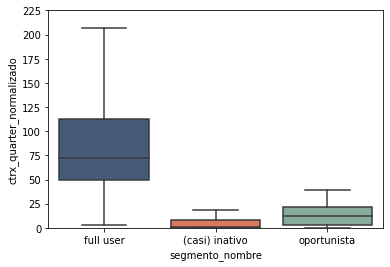

In [116]:
sns.boxplot(x=Xbajas["segmento_nombre"], y=Xbajas['ctrx_quarter_normalizado'], showfliers = False, palette=enmax_palette)
plt.ylim(0,225)
plt.show()

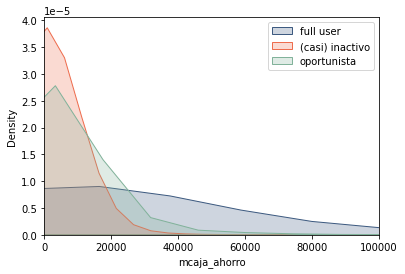

In [117]:
fig = sns.kdeplot(Xbajas.loc[Xbajas['segmento'] == 0, "mcaja_ahorro"], shade=True, color="C0", label = 'full user')
fig = sns.kdeplot(Xbajas.loc[Xbajas['segmento'] == 1, "mcaja_ahorro"], shade=True, color="C1", label = '(casi) inactivo')
fig = sns.kdeplot(Xbajas.loc[Xbajas['segmento'] == 2, "mcaja_ahorro"], shade=True, color="C2", label = 'oportunista')
plt.xlim(0,100000)
plt.legend()
plt.show()

In [111]:
Xbajas.groupby('segmento').has_payroll.sum()

segmento
0    293
1      0
2      0
Name: has_payroll, dtype: int64

In [148]:
tabla = pivot.reset_index()
tabla = tabla[['segmento', 202101, 202102, 202103 ]]
tabla.T.reset_index().iloc[1:,]

,foto_mes,0,1,2
1,202101,54188.26,10940.37,15464.92
2,202102,54805.98,9797.05,15179.84
3,202103,53470.73,6399.71,14632.62


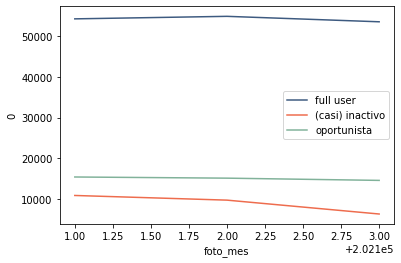

In [150]:
sns.lineplot(x = "foto_mes", y = 0, data=tabla.T.reset_index().iloc[1:,], label = 'full user')
sns.lineplot(x = "foto_mes", y = 1, data=tabla.T.reset_index().iloc[1:,], label = '(casi) inactivo')
sns.lineplot(x = "foto_mes", y = 2, data=tabla.T.reset_index().iloc[1:,], label = 'oportunista')
plt.legend()

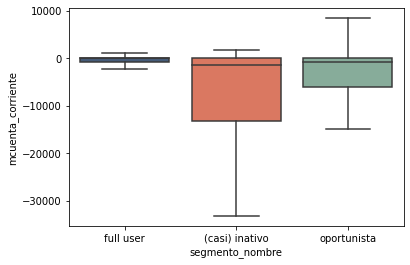

In [151]:
sns.boxplot(x=Xbajas["segmento_nombre"], y=Xbajas['mcuenta_corriente'], showfliers = False, palette=enmax_palette)
#plt.ylim(0,225)
plt.show()

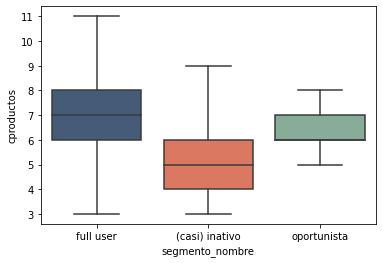

In [152]:
sns.boxplot(x=Xbajas["segmento_nombre"], y=Xbajas['cproductos'], showfliers = False, palette=enmax_palette)
#plt.ylim(0,225)
plt.show()